In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import v2

if 'google.colab' in sys.modules:
    !pip install torchsummary
    !pip install albumentationsx
    !pip install torch_lr_finder

import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from tqdm import tqdm

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True  # <-- important in Jupyter
)
logger = logging.getLogger(__name__)

from model_v1 import ResNet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 33.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.33 which is incompatible.


In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(f"Cuda available = {is_cuda}, Using device = {device}")

Cuda available = True, Using device = cuda


In [4]:
# Mean and Standard Deviation of CIFAR-100 dataset
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)
if 'google.colab' in sys.modules:
    BATCH_SIZE = 1024
else:
    BATCH_SIZE = 32
CIFAR100_LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
logger.info(f"Lenth of class names = {len(CIFAR100_LABELS)}")
GET_DATASET_STATS_FLAG = True

2025-10-08 12:27:01,402 - INFO - Lenth of class names = 100


In [5]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # CIFAR100 gives PIL image -> convert to numpy
        img = np.array(img)
        # Apply Albumentations
        augmented = self.transform(image=img)
        return augmented["image"]

# Denormalization function for viz/stats (add this helper)
def denormalize(tensor_img, mean=CIFAR100_MEAN, std=CIFAR100_STD):
    """Denormalize tensor for display (assumes C x H x W, values in [-2,2] approx)."""
    tensor_img = tensor_img.clone()  # Avoid modifying original
    for t, m, s in zip(tensor_img, mean, std):
        t.mul_(s).add_(m)  # Unnormalize
    return torch.clamp(tensor_img, 0, 1)  # Clamp to [0,1]

train_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=(-0.0625, 0.0625),
        scale_limit=(-0.1, 0.1),
        rotate_limit=(-15, 15),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        rotate_method="largest_box",
        p=0.5),
    A.CoarseDropout(
        num_holes_range=(1,1),
        hole_height_range=(10, 15),
        hole_width_range=(10, 15),
        fill=0,
        p=0.5
    ),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

test_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
cifar_train_dataset = datasets.CIFAR100(
    root='../../',
    train=True,
    download=True,
    transform=train_transforms,
)

cifar_test_dataset = datasets.CIFAR100(
    root='../../',
    train=False,
    download=True,
    transform=test_transforms,
)

train_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 0, 'pin_memory': is_cuda}
test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': False,  'num_workers': 0, 'pin_memory': is_cuda}

train_loader = torch.utils.data.DataLoader(cifar_train_dataset, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(cifar_test_dataset,  **test_kwargs)

100%|██████████| 169M/169M [00:06<00:00, 26.7MB/s]


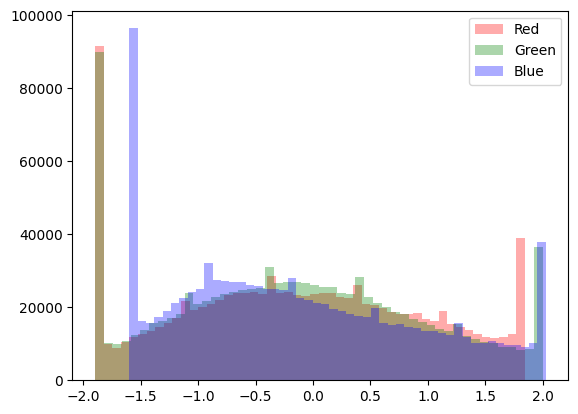

In [7]:
if GET_DATASET_STATS_FLAG:
    # Note: This computes stats on transformed (augmented + normalized) data, which isn't ideal for verifying raw mean/std.
    # If you want raw stats, use a temp dataset without transforms/normalize.
    imgs = []
    for index, item in enumerate(cifar_train_dataset):
        # Sampling 1000 images only
        if index > 1000:
            break
        else:
            imgs.append(item[0])
    # imgs = [item[0] for item in cifar_train_dataset]
    imgs = torch.stack(imgs, dim=0).numpy()
    imgs_r = imgs[:,0,:,:].flatten()
    imgs_g = imgs[:,1,:,:].flatten()
    imgs_b = imgs[:,2,:,:].flatten()
    logger.info(f"Flatten images size {imgs_r.shape}, {imgs_g.shape}, {imgs_b.shape}")

    plt.hist(imgs_r, bins=50, alpha=0.33, color='r', label='Red')
    plt.hist(imgs_g, bins=50, alpha=0.33, color='g', label='Green')
    plt.hist(imgs_b, bins=50, alpha=0.33, color='b', label='Blue')
    plt.legend()
    plt.show()

In [8]:
def dataset_visualizer(dataset_loader, n_images=12):
    """Visualize a few samples from the dataset loader."""
    batch_data, batch_label = next(iter(dataset_loader))
    n_images = min(n_images, len(batch_data))

    fig = plt.figure(figsize=(10, 8))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        image_data = batch_data[i].cpu()
        # Denormalize first (expects C x H x W)
        image_data = denormalize(image_data, mean=CIFAR100_MEAN, std=CIFAR100_STD)
        # Then permute to H x W x C for visualization
        image_data = image_data.permute(1, 2, 0)
        plt.imshow(image_data)
        plt.title(CIFAR100_LABELS[batch_label[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

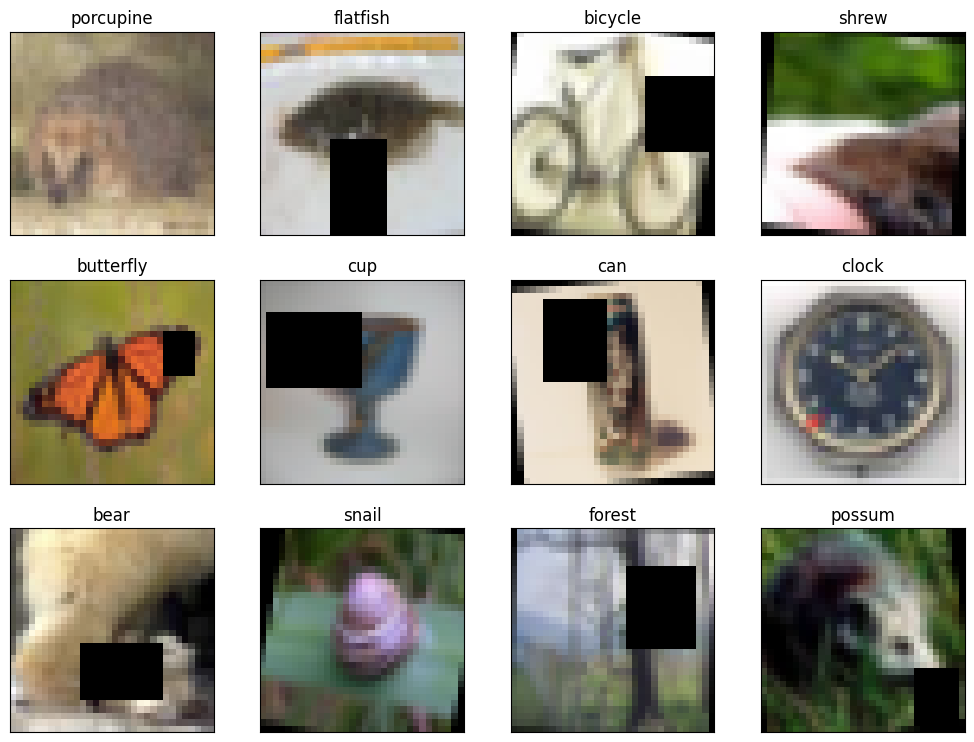

In [9]:
dataset_visualizer(train_loader)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

dummy_data = torch.randn(5, 3, 32, 32).to(device)
dummy_output = model(dummy_data)
print("Output shape:", dummy_output.shape)  # should be [5, 100]
summary(model, input_size=(3, 32, 32), device=str(device))

Output shape: torch.Size([5, 100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
    

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.33E-03


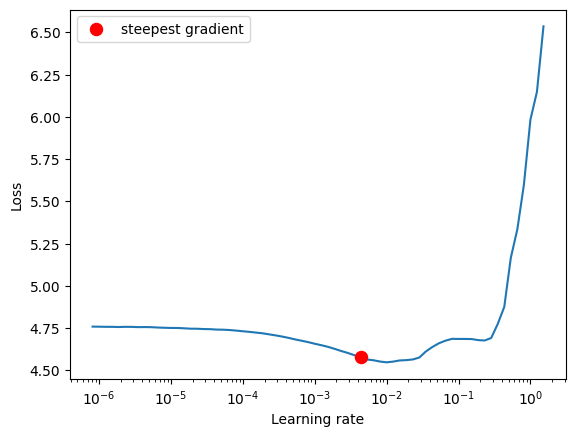

In [8]:
from torch_lr_finder import LRFinder

model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
#4e-3

In [9]:
# Learning rate chosen
lr_from_lr_finder = 4E-3
logger.info(f"Learning rate for one cycle LR = {lr_from_lr_finder}")

2025-10-08 12:29:43,707 - INFO - Learning rate for one cycle LR = 0.004


In [10]:
# ============================================================
# 1️⃣ Checkpoint utilities
# ============================================================

def save_checkpoint(model, optimizer, scheduler, epoch, best_loss, path):
    state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'best_loss': best_loss
    }
    torch.save(state, path)
    logger.info(f"✅ Checkpoint saved at epoch {epoch+1} to {path}")


def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    logger.info(f"✅ Resumed from checkpoint: epoch {start_epoch}, best loss {best_loss:.4f}")
    return start_epoch, best_loss

In [11]:
# ============================================================
# 2️⃣ Training Loop (OneCycleLR integrated)
# ============================================================
criterion = nn.CrossEntropyLoss()
train_loss_data = []
train_accuracy = []
test_loss_data = []
test_accuracy = []
learning_rate_over_steps = []

best_loss = float('inf')   # initialize with infinity

def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()  # OneCycleLR updates per batch

        learning_rate_over_steps.append(optimizer.param_groups[0]['lr'])

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        pbar.set_description(desc=f'loss={loss.item():.4f} batch_id={batch_idx}')

    # Epoch-level stats
    avg_loss = running_loss / len(train_loader)
    acc = 100. * correct / total

    train_loss_data.append(avg_loss)
    train_accuracy.append(acc)

    print(f'\nTrain set (epoch {epoch}): Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({acc:.2f}%)\n')

# ============================================================
# 3️⃣ Testing Loop
# ============================================================

def test(model, device, test_loader, epoch):
    global best_loss  # to update across epochs
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_data.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(acc)

    print(f'Test set (epoch {epoch}): Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')

    # ✅ Save best model by lowest test loss
    if test_loss < best_loss:
        best_loss = test_loss
        save_dir = "/content/drive/MyDrive/CIFAR100" if 'google.colab' in sys.modules else "."
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pt"))
        print(f"✅ Saved new best model at epoch {epoch} with loss {best_loss:.4f}")

    return test_loss


In [12]:
# ============================================================
# 3️⃣ Model, optimizer, scheduler setup
# ============================================================

# Example: customize your ResNet to use partial depthwise convs
model = ResNet(layers=[2, 2, 3, 2], num_classes=100,
               use_depthwise=(False, False, True, True)).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# You already ran LR Finder earlier and got:
max_lr = lr_from_lr_finder   # Use from LR Finder output
total_epochs = 40 # Full plan (even if train 20+20)
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=total_epochs,
    pct_start=0.3,
    anneal_strategy="cos",
    div_factor=25.0,
    final_div_factor=1e4,
)

# ============================================================
# 4️⃣ Resume if checkpoint exists
# ============================================================

start_epoch = 0
save_dir = "/content/drive/MyDrive/CIFAR100" if 'google.colab' in sys.modules else "."
os.makedirs(save_dir, exist_ok=True)
save_dir_file_name = os.path.join(save_dir, "checkpoint.pt")
if os.path.exists(save_dir_file_name):
    logger.info("Found checkpoint, loading checkpoint ...")
    start_epoch, best_loss = load_checkpoint(model, optimizer, scheduler, save_dir_file_name, device)
else:
    best_loss = float("inf")

# ============================================================
# 5️⃣ Main training loop
# ============================================================

for epoch in range(start_epoch, total_epochs):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test_loss = test(model, device, test_loader, epoch)
    save_checkpoint(model, optimizer, scheduler, epoch, best_loss, save_dir_file_name)

loss=4.1090 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it]



Train set (epoch 0): Average loss: 4.3801, Accuracy: 2362/50000 (4.72%)



2025-10-08 12:31:11,455 - INFO - ✅ Checkpoint saved at epoch 1 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 0): Average loss: 4.3700, Accuracy: 535/10000 (5.35%)

✅ Saved new best model at epoch 0 with loss 4.3700


loss=3.6239 batch_id=48: 100%|██████████| 49/49 [00:55<00:00,  1.13s/it]



Train set (epoch 1): Average loss: 3.8590, Accuracy: 5758/50000 (11.52%)



2025-10-08 12:32:10,553 - INFO - ✅ Checkpoint saved at epoch 2 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 1): Average loss: 3.6562, Accuracy: 1376/10000 (13.76%)

✅ Saved new best model at epoch 1 with loss 3.6562


loss=3.2636 batch_id=48: 100%|██████████| 49/49 [00:55<00:00,  1.14s/it]



Train set (epoch 2): Average loss: 3.4401, Accuracy: 8843/50000 (17.69%)



2025-10-08 12:33:09,617 - INFO - ✅ Checkpoint saved at epoch 3 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 2): Average loss: 3.3870, Accuracy: 1819/10000 (18.19%)

✅ Saved new best model at epoch 2 with loss 3.3870


loss=3.0501 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 3): Average loss: 3.0988, Accuracy: 11713/50000 (23.43%)



2025-10-08 12:34:09,942 - INFO - ✅ Checkpoint saved at epoch 4 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 3): Average loss: 3.2361, Accuracy: 2144/10000 (21.44%)

✅ Saved new best model at epoch 3 with loss 3.2361


loss=2.6352 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it]



Train set (epoch 4): Average loss: 2.7922, Accuracy: 14633/50000 (29.27%)



2025-10-08 12:35:10,891 - INFO - ✅ Checkpoint saved at epoch 5 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 4): Average loss: 3.0394, Accuracy: 2682/10000 (26.82%)

✅ Saved new best model at epoch 4 with loss 3.0394


loss=2.5564 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it]



Train set (epoch 5): Average loss: 2.4976, Accuracy: 17442/50000 (34.88%)



2025-10-08 12:36:12,389 - INFO - ✅ Checkpoint saved at epoch 6 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 5): Average loss: 2.8406, Accuracy: 3095/10000 (30.95%)

✅ Saved new best model at epoch 5 with loss 2.8406


loss=2.1698 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it]



Train set (epoch 6): Average loss: 2.2740, Accuracy: 19865/50000 (39.73%)



2025-10-08 12:37:14,005 - INFO - ✅ Checkpoint saved at epoch 7 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 6): Average loss: 2.5000, Accuracy: 3599/10000 (35.99%)

✅ Saved new best model at epoch 6 with loss 2.5000


loss=2.1183 batch_id=48: 100%|██████████| 49/49 [00:58<00:00,  1.20s/it]



Train set (epoch 7): Average loss: 2.0647, Accuracy: 22065/50000 (44.13%)



2025-10-08 12:38:16,709 - INFO - ✅ Checkpoint saved at epoch 8 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 7): Average loss: 2.5676, Accuracy: 3731/10000 (37.31%)



loss=1.8726 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it]



Train set (epoch 8): Average loss: 1.8962, Accuracy: 23987/50000 (47.97%)



2025-10-08 12:39:17,544 - INFO - ✅ Checkpoint saved at epoch 9 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 8): Average loss: 2.3153, Accuracy: 4158/10000 (41.58%)

✅ Saved new best model at epoch 8 with loss 2.3153


loss=1.7129 batch_id=48: 100%|██████████| 49/49 [01:00<00:00,  1.24s/it]



Train set (epoch 9): Average loss: 1.7644, Accuracy: 25453/50000 (50.91%)



2025-10-08 12:40:22,197 - INFO - ✅ Checkpoint saved at epoch 10 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 9): Average loss: 2.6260, Accuracy: 3830/10000 (38.30%)



loss=1.6954 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.16s/it]



Train set (epoch 10): Average loss: 1.6254, Accuracy: 27255/50000 (54.51%)



2025-10-08 12:41:22,716 - INFO - ✅ Checkpoint saved at epoch 11 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 10): Average loss: 2.2115, Accuracy: 4382/10000 (43.82%)

✅ Saved new best model at epoch 10 with loss 2.2115


loss=1.6029 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it]



Train set (epoch 11): Average loss: 1.5177, Accuracy: 28540/50000 (57.08%)



2025-10-08 12:42:24,058 - INFO - ✅ Checkpoint saved at epoch 12 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 11): Average loss: 1.9137, Accuracy: 4890/10000 (48.90%)

✅ Saved new best model at epoch 11 with loss 1.9137


loss=1.4998 batch_id=48: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]



Train set (epoch 12): Average loss: 1.4262, Accuracy: 29583/50000 (59.17%)



2025-10-08 12:43:27,129 - INFO - ✅ Checkpoint saved at epoch 13 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 12): Average loss: 1.9439, Accuracy: 4963/10000 (49.63%)



loss=1.3365 batch_id=48: 100%|██████████| 49/49 [00:59<00:00,  1.21s/it]



Train set (epoch 13): Average loss: 1.3002, Accuracy: 31172/50000 (62.34%)



2025-10-08 12:44:30,442 - INFO - ✅ Checkpoint saved at epoch 14 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 13): Average loss: 1.8327, Accuracy: 5146/10000 (51.46%)

✅ Saved new best model at epoch 13 with loss 1.8327


loss=1.2593 batch_id=48: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it]



Train set (epoch 14): Average loss: 1.2353, Accuracy: 32054/50000 (64.11%)



2025-10-08 12:45:32,795 - INFO - ✅ Checkpoint saved at epoch 15 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 14): Average loss: 1.8284, Accuracy: 5247/10000 (52.47%)

✅ Saved new best model at epoch 14 with loss 1.8284


loss=1.2087 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it]



Train set (epoch 15): Average loss: 1.1378, Accuracy: 33227/50000 (66.45%)



2025-10-08 12:46:34,252 - INFO - ✅ Checkpoint saved at epoch 16 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 15): Average loss: 1.8087, Accuracy: 5330/10000 (53.30%)

✅ Saved new best model at epoch 15 with loss 1.8087


loss=1.1715 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it]



Train set (epoch 16): Average loss: 1.0705, Accuracy: 34184/50000 (68.37%)



2025-10-08 12:47:35,439 - INFO - ✅ Checkpoint saved at epoch 17 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 16): Average loss: 1.6962, Accuracy: 5520/10000 (55.20%)

✅ Saved new best model at epoch 16 with loss 1.6962


loss=1.0095 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 17): Average loss: 1.0012, Accuracy: 35000/50000 (70.00%)

Test set (epoch 17): Average loss: 1.5799, Accuracy: 5713/10000 (57.13%)

✅ Saved new best model at epoch 17 with loss 1.5799


2025-10-08 12:48:36,449 - INFO - ✅ Checkpoint saved at epoch 18 to /content/drive/MyDrive/CIFAR100/checkpoint.pt
loss=1.0261 batch_id=48: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it]



Train set (epoch 18): Average loss: 0.9214, Accuracy: 36146/50000 (72.29%)



2025-10-08 12:49:38,165 - INFO - ✅ Checkpoint saved at epoch 19 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 18): Average loss: 1.6661, Accuracy: 5630/10000 (56.30%)



loss=0.9543 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it]



Train set (epoch 19): Average loss: 0.8553, Accuracy: 36980/50000 (73.96%)



2025-10-08 12:50:38,647 - INFO - ✅ Checkpoint saved at epoch 20 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 19): Average loss: 1.6521, Accuracy: 5735/10000 (57.35%)



loss=0.8251 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 20): Average loss: 0.8033, Accuracy: 37754/50000 (75.51%)



2025-10-08 12:51:39,049 - INFO - ✅ Checkpoint saved at epoch 21 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 20): Average loss: 1.4952, Accuracy: 6042/10000 (60.42%)

✅ Saved new best model at epoch 20 with loss 1.4952


loss=0.7549 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.16s/it]



Train set (epoch 21): Average loss: 0.7251, Accuracy: 38980/50000 (77.96%)



2025-10-08 12:52:39,994 - INFO - ✅ Checkpoint saved at epoch 22 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 21): Average loss: 1.5885, Accuracy: 5966/10000 (59.66%)



loss=0.6975 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 22): Average loss: 0.6642, Accuracy: 39873/50000 (79.75%)



2025-10-08 12:53:40,018 - INFO - ✅ Checkpoint saved at epoch 23 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 22): Average loss: 1.5080, Accuracy: 6215/10000 (62.15%)



loss=0.6646 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.18s/it]



Train set (epoch 23): Average loss: 0.6007, Accuracy: 40736/50000 (81.47%)



2025-10-08 12:54:41,323 - INFO - ✅ Checkpoint saved at epoch 24 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 23): Average loss: 1.5952, Accuracy: 6084/10000 (60.84%)



loss=0.5466 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it]



Train set (epoch 24): Average loss: 0.5322, Accuracy: 41776/50000 (83.55%)



2025-10-08 12:55:40,965 - INFO - ✅ Checkpoint saved at epoch 25 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 24): Average loss: 1.5160, Accuracy: 6286/10000 (62.86%)



loss=0.5098 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 25): Average loss: 0.4696, Accuracy: 42876/50000 (85.75%)



2025-10-08 12:56:41,428 - INFO - ✅ Checkpoint saved at epoch 26 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 25): Average loss: 1.4702, Accuracy: 6323/10000 (63.23%)

✅ Saved new best model at epoch 25 with loss 1.4702


loss=0.4383 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 26): Average loss: 0.4105, Accuracy: 43715/50000 (87.43%)



2025-10-08 12:57:42,040 - INFO - ✅ Checkpoint saved at epoch 27 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 26): Average loss: 1.3567, Accuracy: 6567/10000 (65.67%)

✅ Saved new best model at epoch 26 with loss 1.3567


loss=0.3400 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 27): Average loss: 0.3562, Accuracy: 44580/50000 (89.16%)



2025-10-08 12:58:42,305 - INFO - ✅ Checkpoint saved at epoch 28 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 27): Average loss: 1.3478, Accuracy: 6629/10000 (66.29%)

✅ Saved new best model at epoch 27 with loss 1.3478


loss=0.3175 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it]



Train set (epoch 28): Average loss: 0.3080, Accuracy: 45323/50000 (90.65%)



2025-10-08 12:59:43,668 - INFO - ✅ Checkpoint saved at epoch 29 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 28): Average loss: 1.3342, Accuracy: 6718/10000 (67.18%)

✅ Saved new best model at epoch 28 with loss 1.3342


loss=0.2648 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it]



Train set (epoch 29): Average loss: 0.2657, Accuracy: 46085/50000 (92.17%)



2025-10-08 13:00:43,565 - INFO - ✅ Checkpoint saved at epoch 30 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 29): Average loss: 1.3431, Accuracy: 6672/10000 (66.72%)



loss=0.2367 batch_id=48: 100%|██████████| 49/49 [01:01<00:00,  1.25s/it]



Train set (epoch 30): Average loss: 0.2191, Accuracy: 46872/50000 (93.74%)



2025-10-08 13:01:48,005 - INFO - ✅ Checkpoint saved at epoch 31 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 30): Average loss: 1.3397, Accuracy: 6776/10000 (67.76%)



loss=0.1799 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.15s/it]



Train set (epoch 31): Average loss: 0.1854, Accuracy: 47431/50000 (94.86%)



2025-10-08 13:02:48,643 - INFO - ✅ Checkpoint saved at epoch 32 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 31): Average loss: 1.2689, Accuracy: 6924/10000 (69.24%)

✅ Saved new best model at epoch 31 with loss 1.2689


loss=0.1661 batch_id=48: 100%|██████████| 49/49 [00:58<00:00,  1.19s/it]



Train set (epoch 32): Average loss: 0.1574, Accuracy: 47830/50000 (95.66%)



2025-10-08 13:03:50,175 - INFO - ✅ Checkpoint saved at epoch 33 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 32): Average loss: 1.2847, Accuracy: 6891/10000 (68.91%)



loss=0.1848 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it]



Train set (epoch 33): Average loss: 0.1370, Accuracy: 48170/50000 (96.34%)



2025-10-08 13:04:50,733 - INFO - ✅ Checkpoint saved at epoch 34 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 33): Average loss: 1.2829, Accuracy: 6926/10000 (69.26%)



loss=0.1090 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 34): Average loss: 0.1197, Accuracy: 48465/50000 (96.93%)



2025-10-08 13:05:51,502 - INFO - ✅ Checkpoint saved at epoch 35 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 34): Average loss: 1.2738, Accuracy: 6960/10000 (69.60%)



loss=0.1182 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 35): Average loss: 0.1084, Accuracy: 48618/50000 (97.24%)



2025-10-08 13:06:51,623 - INFO - ✅ Checkpoint saved at epoch 36 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 35): Average loss: 1.2649, Accuracy: 6953/10000 (69.53%)

✅ Saved new best model at epoch 35 with loss 1.2649


loss=0.1007 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 36): Average loss: 0.0999, Accuracy: 48777/50000 (97.55%)



2025-10-08 13:07:52,311 - INFO - ✅ Checkpoint saved at epoch 37 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 36): Average loss: 1.2662, Accuracy: 6979/10000 (69.79%)



loss=0.0826 batch_id=48: 100%|██████████| 49/49 [00:56<00:00,  1.16s/it]



Train set (epoch 37): Average loss: 0.0968, Accuracy: 48797/50000 (97.59%)



2025-10-08 13:08:52,771 - INFO - ✅ Checkpoint saved at epoch 38 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 37): Average loss: 1.2644, Accuracy: 6988/10000 (69.88%)

✅ Saved new best model at epoch 37 with loss 1.2644


loss=0.0986 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it]



Train set (epoch 38): Average loss: 0.0941, Accuracy: 48844/50000 (97.69%)



2025-10-08 13:09:53,530 - INFO - ✅ Checkpoint saved at epoch 39 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 38): Average loss: 1.2623, Accuracy: 6984/10000 (69.84%)

✅ Saved new best model at epoch 38 with loss 1.2623


loss=0.0970 batch_id=48: 100%|██████████| 49/49 [00:57<00:00,  1.17s/it]



Train set (epoch 39): Average loss: 0.0907, Accuracy: 48887/50000 (97.77%)



2025-10-08 13:10:54,488 - INFO - ✅ Checkpoint saved at epoch 40 to /content/drive/MyDrive/CIFAR100/checkpoint.pt


Test set (epoch 39): Average loss: 1.2629, Accuracy: 6987/10000 (69.87%)



In [ ]:
# To disconnect and exit!
# from IPython.display import Javascript, display

# display(Javascript('google.colab.kernel.disconnect();'))


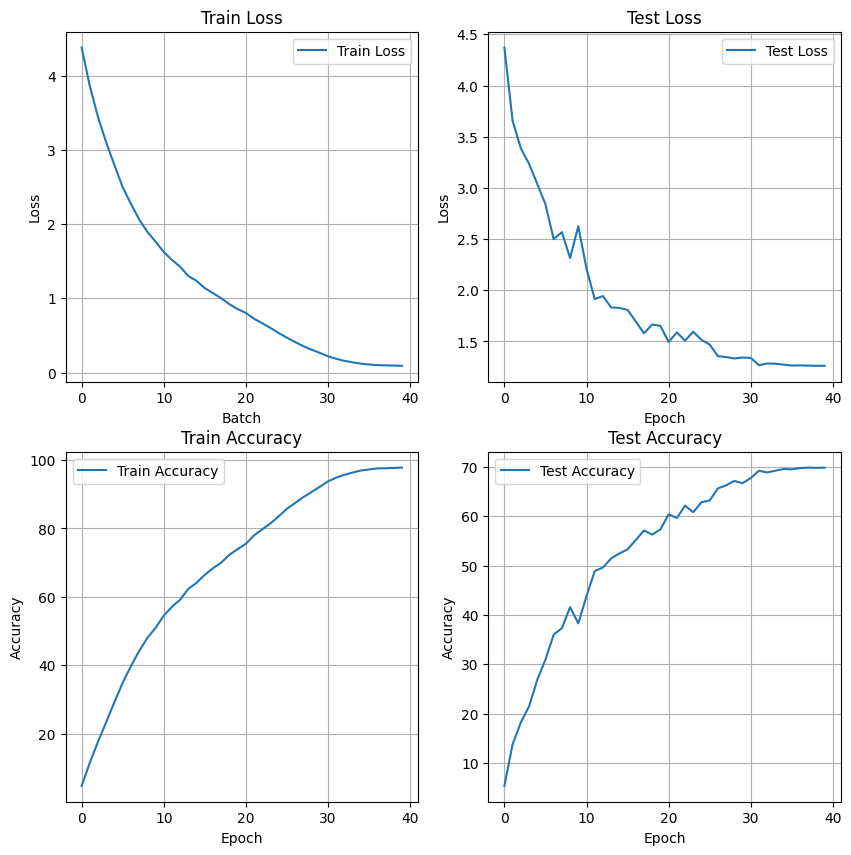

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(train_loss_data, label='Train Loss')
axs[0,0].set_xlabel('Batch')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('Train Loss')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(test_loss_data, label='Test Loss')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Test Loss')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(train_accuracy, label='Train Accuracy')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('Train Accuracy')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(test_accuracy, label='Test Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Test Accuracy')
axs[1,1].grid(True)
axs[1,1].legend()

plt.show()

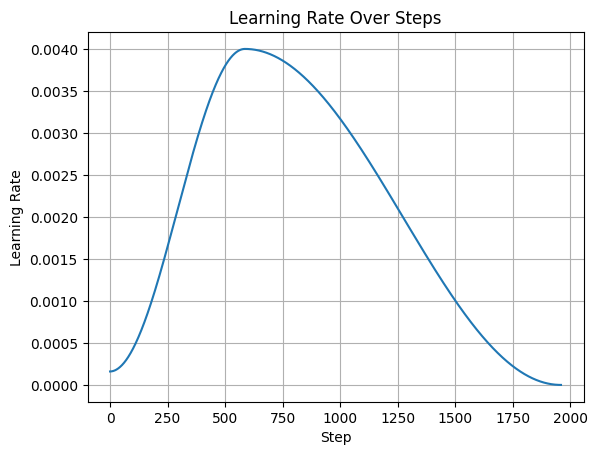

In [14]:
plt.plot(learning_rate_over_steps)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Steps')
plt.grid(True)
plt.show()